# Classifying movie reviews with tf.keras and tf.data

In this notebook you'll learn how to classify a movie review as positive or negative on the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb). This tutorial was inspired by [this work](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.5-classifying-movie-reviews.ipynb). Here, we'll continue to use `tf.keras` and `tf.data`.

In [1]:
import tensorflow as tf

import numpy as np

# A first look at the dataset

### Step 1) Downloading the dataset

The "IMDB dataset" is a set of around 50,000 positive or negative reviews for movies from the Internet Movie Database. Let's use the TensorFlow API to download the dataset the same way we did for Fashion-MNIST. The `num_words` argument is how many of the most popular words we will keep. All other "rare" words will be discarded.

In [2]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=10000)

### Step 2) Exploring the dataset 

The dataset comes preprocessed. Each example is an array of integers representing the words of the movie review. Each label is either a "0" for negative or "1" for positive.

In [3]:
print(train_data.shape)
print(train_labels.shape)
print(train_data[0])
print(train_labels[0])

(25000,)
(25000,)
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1



### Word indexing

To prove we have limited ourselves to the 10,000 most frequent words we will iterate over all the reviews and check the maximum value. 

In [4]:
print(max([max(review) for review in train_data]))

9999


### Converting the integers back to words

We can get the dictionary from `tf.keras.datasets.imdb.get_word_index` which hashes the words to their corresponding integers. Let's try and convert a review from integers back into it's original text by first reversing this dictionary and then iterating over a review and converting the integers to strings.

In [5]:
# Dictionary that hashes words to their integer
word_to_integer = tf.keras.datasets.imdb.get_word_index()

# Print out the first ten keys in the dictionary
print(list(word_to_integer.keys())[0:10])

integer_to_word = dict([(value, key) for (key, value) in word_to_integer.items()])

# Demonstrate how to find the word from an integer
print(integer_to_word[1])
print(integer_to_word[2])

# We need to subtract 3 from the indices because 0 is "padding", 1 is "start of sequence", and 2 is "unknown"
decoded_review = ' '.join([integer_to_word.get(i - 3, 'UNK') for i in train_data[0]])
print(decoded_review)

['fawn', 'tsukino', 'nunnery', 'sonja', 'vani', 'woods', 'spiders', 'hanging', 'woody', 'trawling']
the
and
UNK this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert UNK is an amazing actor and now the same being director UNK father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for UNK and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also UNK to the two little boy's that played the UNK of norman and paul they were just brilliant children are often left out of the UNK list i think because the stars that play them all grown up are such a

### Step 3) Format the data
Unfortunately, we cannot just feed unformatted arrays into our neural network. We need to standardize the input. Here, we are going to multi-hot-encode our review which is an array of integers into a 10,000 dimensional vector. We will place 1's in the indices of word-integers that occur in the review, and 0's everywhere else.


In [6]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

train_data = vectorize_sequences(train_data)
test_data = vectorize_sequences(test_data)

print(train_data.shape) # length is same as before
print(train_data[0]) # now, multi-hot encoded

# Vectorize the labels as well and reshape from (N, ) to (N, 1)
train_labels = np.reshape(np.asarray(train_labels, dtype=np.float32), (len(train_data), 1))
test_labels = np.reshape(np.asarray(test_labels, dtype=np.float32), (len(test_data), 1))

(25000, 10000)
[0. 1. 1. ... 0. 0. 0.]


### Step 4) Create the model

Now that we have vectorized input, we're ready to build our neural network. We're going to use multiple hidden layers, each with 16 hidden units. The more layers and hidden units you have, the more complicated patterns the network can recognize and learn. 

* The downside is that a large number potentially leads to [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) by finding patterns that may only exist in your training not (and not generalize to unseen testing data down the road).

Instead of softmax as in the previous notebook, here our last activation will be a sigmoid. This will take the output of the first two layers and "squish" it into a number between 0 and 1 (the network's prediction for the review).

In [7]:
# Create a model
model = tf.keras.Sequential()

 # input shape here is the length of our movie review vector
model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(10000,)))
model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['binary_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


### Step 5) Create a validation set

We want to test our model on data it hasn't seen before, but before we get our final test accuracy. We'll call this dataset our validation set. In practice, it's used to tune parameters like your learning rate, or the number of layers / units in your model.

In [8]:
VAL_SIZE = 10000

val_data = train_data[:VAL_SIZE]
partial_train_data = train_data[VAL_SIZE:]


val_labels = train_labels[:VAL_SIZE]
partial_train_labels = train_labels[VAL_SIZE:]

### Step 6) Create a tf.data Dataset
As before, we're working with a small in-memory dataset, so converting to `tf.data` isn't essential, just good practice for down the road. See the previous notebook or the `tf.data.Dataset` [API doc](https://www.tensorflow.org/api_docs/python/tf/data) for more info.

In [9]:
BATCH_SIZE = 512
SHUFFLE_SIZE = 1000

training_set = tf.data.Dataset.from_tensor_slices((partial_train_data, partial_train_labels))
training_set = training_set.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)

### Step 7) Training your model
Now we are going to train the model. As we go, we'll keep track of the training loss, training accuracy, validation loss, and validation accuracy. 

Please be patient as this step may take a while.

In [10]:
EPOCHS = 10

# Store list of metric values for plotting later
tr_loss_list = []
tr_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

for epoch in range(EPOCHS):
    for reviews, labels in training_set:
        # Calculate training loss and accuracy
        tr_loss, tr_accuracy = model.train_on_batch(reviews, labels)
  
    # Calculate validation loss and accuracy
    val_loss, val_accuracy = model.evaluate(val_data, val_labels)

    # Add to the lists
    tr_loss_list.append(tr_loss)
    tr_accuracy_list.append(tr_accuracy)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
  
    print(('Epoch #%d\t Training Loss: %.2f\tTraining Accuracy: %.2f\t'
           'Validation Loss: %.2f\tValidation Accuracy: %.2f') % (epoch + 1,
                                                                  tr_loss, 
                                                                  tr_accuracy,
                                                                  val_loss,
                                                                  val_accuracy))

10000/10000==============================] - 1s 65us/sample - loss: 0.4030 - binary_accuracy: 0.8775
Epoch #1	 Training Loss: 0.41	Training Accuracy: 0.87	Validation Loss: 0.40	Validation Accuracy: 0.88
10000/10000==============================] - 1s 58us/sample - loss: 0.3094 - binary_accuracy: 0.8911
Epoch #2	 Training Loss: 0.24	Training Accuracy: 0.91	Validation Loss: 0.31	Validation Accuracy: 0.89
10000/10000==============================] - 1s 60us/sample - loss: 0.2805 - binary_accuracy: 0.8927
Epoch #3	 Training Loss: 0.16	Training Accuracy: 0.95	Validation Loss: 0.28	Validation Accuracy: 0.89
10000/10000==============================] - 1s 58us/sample - loss: 0.2739 - binary_accuracy: 0.8915
Epoch #4	 Training Loss: 0.10	Training Accuracy: 0.96	Validation Loss: 0.27	Validation Accuracy: 0.89
10000/10000==============================] - 1s 60us/sample - loss: 0.2773 - binary_accuracy: 0.8896
Epoch #5	 Training Loss: 0.07	Training Accuracy: 0.99	Validation Loss: 0.28	Validation 

### Step 8) Plotting loss and accuracy
We are going to use `matplotlib` to plot our training and validation metrics.

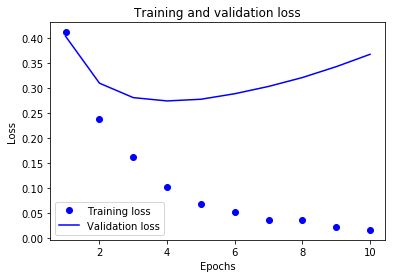

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

# "bo" specifies "blue dot"
plt.plot(epochs, tr_loss_list, 'bo', label='Training loss')
# b specifies a "solid blue line"
plt.plot(epochs, val_loss_list, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

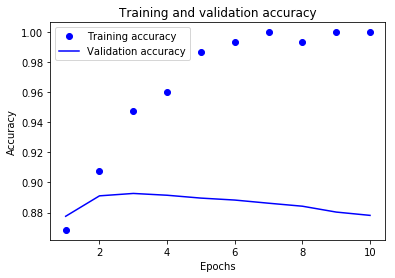

In [12]:
plt.clf()   # Clear plot

plt.plot(epochs, tr_accuracy_list, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy_list, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Step 9) Testing your model
Now that we have successfully trained our model and our training accuracy has jumped over 95%, we need to test it on an entirely different dataset. We are going to run our model on the test set. The test accuracy is a better evaluation metric for how our model will perform in the real world. 

In [13]:
loss, accuracy = model.evaluate(test_data, test_labels)
print('Test accuracy: %.2f' % (accuracy))

25000/25000==============================] - 1s 59us/sample - loss: 0.4031 - binary_accuracy: 0.8637
Test accuracy: 0.86


## Congratulations
You have successfully trained a model on the IMDB dataset.